In [1]:
## DEPENDENCIES
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# 0.1. Data Loading

In [2]:
## READ THE DATA FROM DIRECTORY

# change the raw_dir variable to the windows path where the data is
raw_dir = r'data'
directory = Path(raw_dir)

# this list will hold all the dataframes
dataframes = []

# scrape through directory and read all the files
for file in directory.rglob('*.csv'):
    df = pd.read_csv(file)
    dataframes.append(df)

# CONCATENATE ALL DATAFRAMES INTO A SINGLE DATAFRAME
data = pd.concat(dataframes, ignore_index=True)

In [3]:
# check for duplicate rows
duplicates = data.duplicated(keep=False)
identical_rows = data[duplicates]

# remove the duplicate rows
df = data.drop_duplicates()

#display sample
df.head(5)

,Date,Plt,Well,WellID,Time_h,RawOD,Col,Row,Cpd,Qrt,uM,Species,Strain,Nick,Dil
0,2022-05-04,4,M1,1-4-M1,0.00,0.217,1,M,Azithromycin,1,100.0,S. flexneri,M90T,Sf,100x
1,2022-05-04,4,M1,1-4-M1,1.08,0.233,1,M,Azithromycin,1,100.0,S. flexneri,M90T,Sf,100x
2,2022-05-04,4,M1,1-4-M1,2.16,0.213,1,M,Azithromycin,1,100.0,S. flexneri,M90T,Sf,100x
3,2022-05-04,4,M1,1-4-M1,3.24,0.213,1,M,Azithromycin,1,100.0,S. flexneri,M90T,Sf,100x
4,2022-05-04,4,M1,1-4-M1,4.32,0.212,1,M,Azithromycin,1,100.0,S. flexneri,M90T,Sf,100x


In [4]:
# how many unique days of data in it?
df['Date'].unique()

array(['2022-05-04', '2022-05-05', '2022-05-13'], dtype=object)

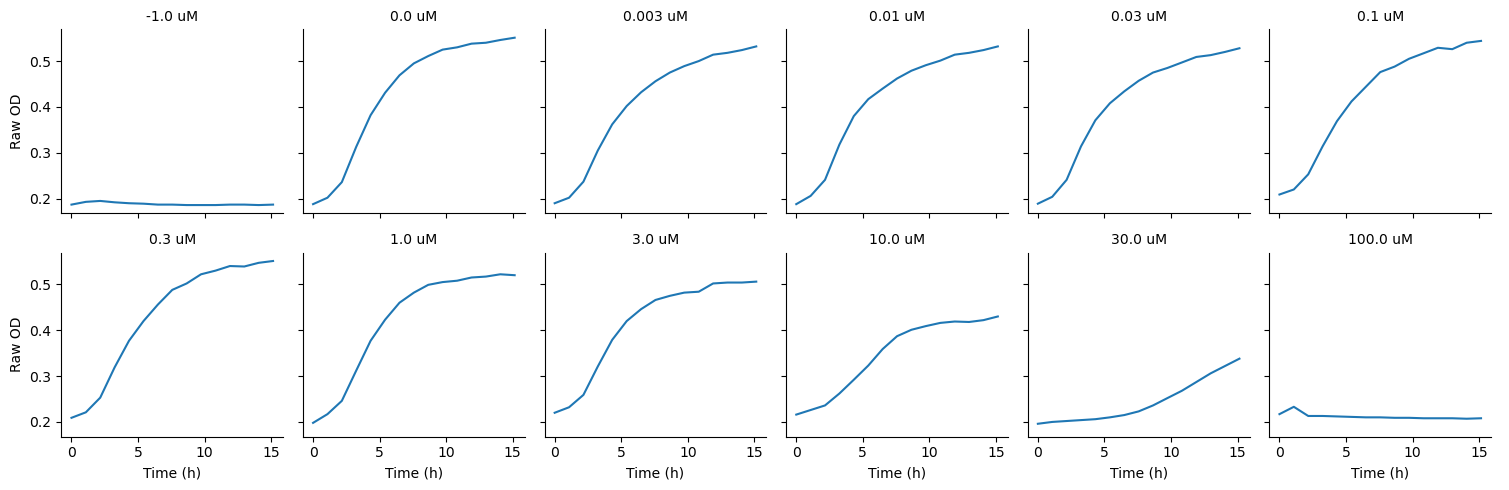

In [5]:
# Plot rawOD and time_h for single day
selected_date = '2022-05-04'

# Filter the DataFrame for the selected date
filtered_df = df[df['Date'] == selected_date]

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM', col_wrap=6, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'RawOD')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'Raw OD')
g.add_legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

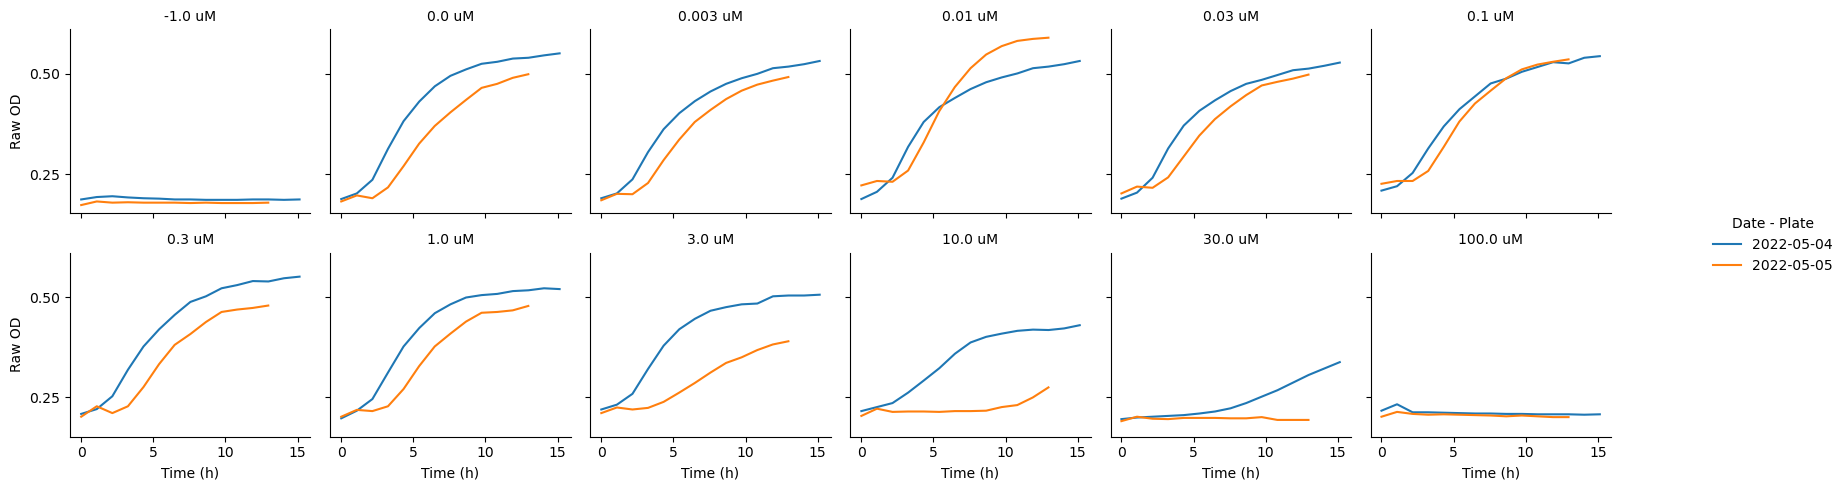

In [6]:
# Plot rawOD and time_h for two days
selected_date = ['2022-05-04','2022-05-05']

# Filter the DataFrame for the selected dates
filtered_df = df[df['Date'].isin(selected_date)]

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM', hue = 'Date', col_wrap=6, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'RawOD')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'Raw OD')

# Set custom y-ticks
g.set(yticks=[0.25, 0.50])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

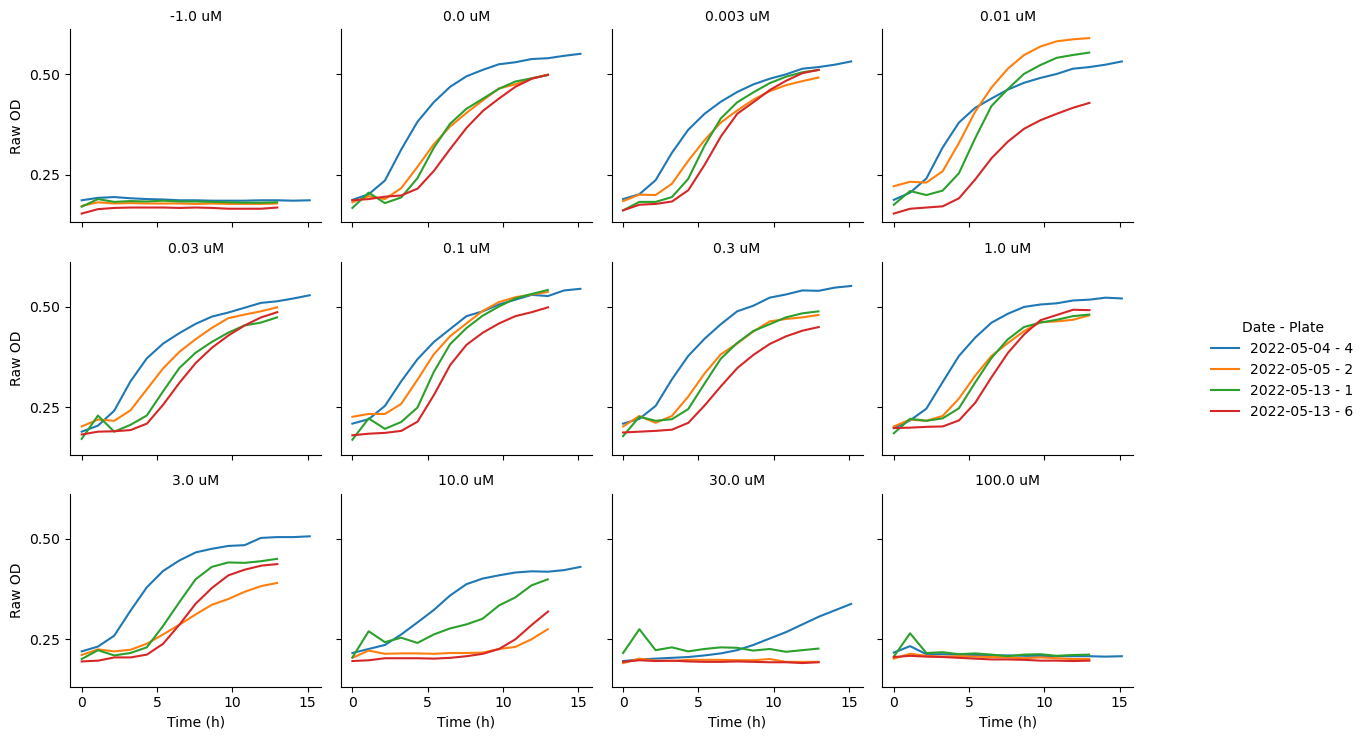

In [7]:
# Plot rawOD and time_h For three days and all plates
selected_dates = df['Date'].unique()

# Filter the DataFrame for the selected dates
filtered_df = df[df['Date'].isin(selected_dates)]

# Create a new column that combines Date and Plt for the hue
filtered_df['Date_Plt'] = filtered_df['Date'] + ' - ' + filtered_df['Plt'].astype(str)

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM',hue='Date_Plt', col_wrap=4, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'RawOD')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'Raw OD')

# Set custom y-ticks
g.set(yticks=[0.25, 0.50])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# 0.2. Feature engineering

In [8]:
# Derived variables for analysis

df = df.copy()

# Create a new column that combines Date, Plt and Time_h, this will help in grouping
df.loc[:, 'Date_Plt_Timeh'] = df['Date'] + ' - ' + df['Plt'].astype(str) + ' - ' + df['Time_h'].astype(str)

## 0.2.1. Add OD column

In [9]:
## ADDING OD VALUES
# for each date AND Plt AND time_point, sort from uM to -1 and add mean of -1 to all
# then subtract that value from RawOD to get a refined OD


# Calculate mean RawOD for each Date_Plt_Timeh where uM == -1
mean_RawOD_minusone = df[df['uM'] == -1].groupby('Date_Plt_Timeh')['RawOD'].mean()


# Add this series to the original DataFrame as the new column
df.loc[:, 'mean_RawOD_minus1'] = df['Date_Plt_Timeh'].map(mean_RawOD_minusone)


# Now add final OD column
df.loc[:, 'OD'] = df['RawOD'] - df['mean_RawOD_minus1']

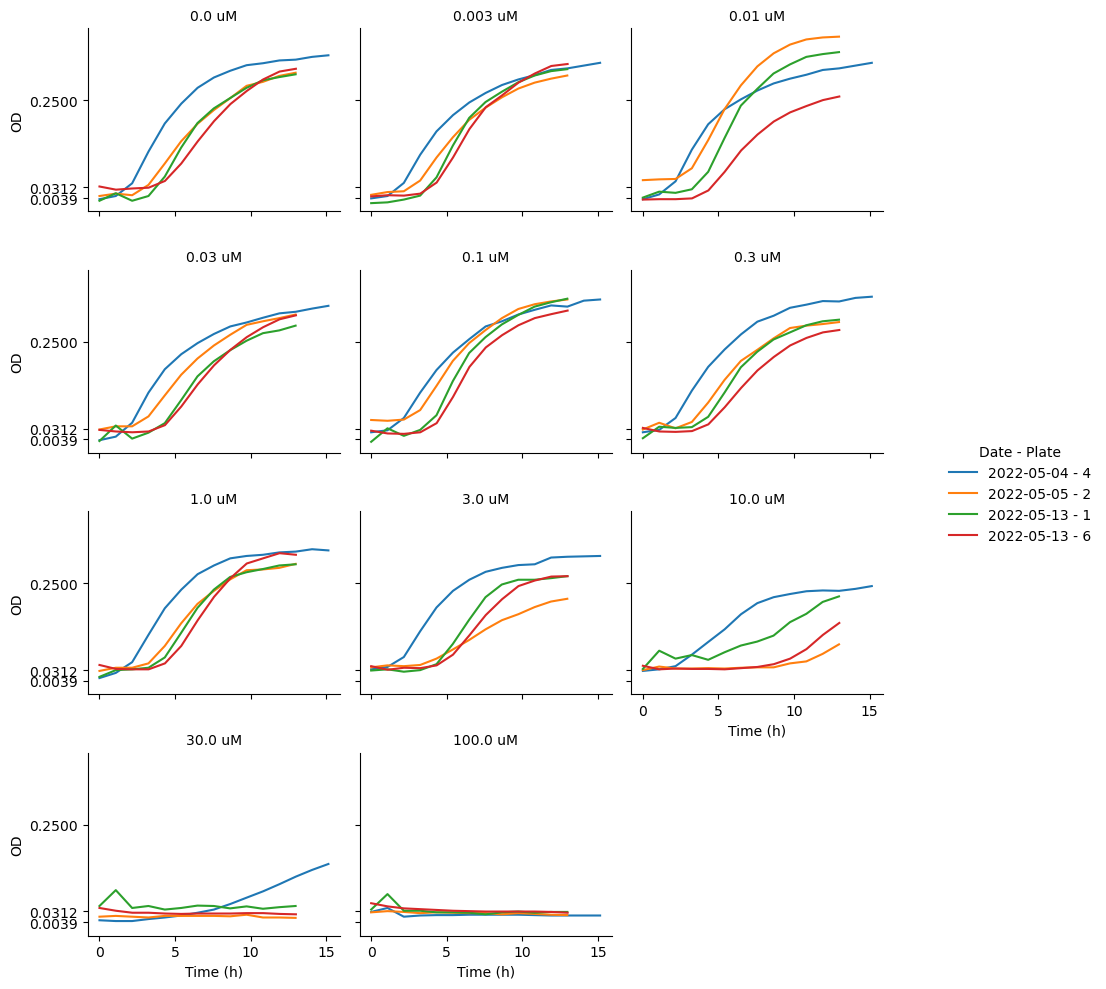

In [10]:
# Plot OD and time_h for all three days and all plates but exclude uM=-1
selected_dates = df['Date'].unique()

# Filter the DataFrame for the selected date
filtered_df = df[df['Date'].isin(selected_dates)]

# Filter the DataFrame to exclude um=-1
filtered_df = df[df['uM'] != -1].copy()

# Create a new column that combines Date and Plt for the hue
filtered_df.loc[:,'Date_Plt'] = df['Date'] + ' - ' + df['Plt'].astype(str)

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM',hue='Date_Plt', col_wrap=3, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'OD')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'OD')


# Set custom y-ticks
g.set(yticks=[0.00390625, 0.03125000,0.25000000])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)


# Adjust layout to prevent overlap
plt.tight_layout()


# Show the plot
plt.show()

In [11]:
# All rows with value less then 0.03 shud be replaced with 0.03
df.loc[df['OD'] < 0.03, 'OD'] = 0.03

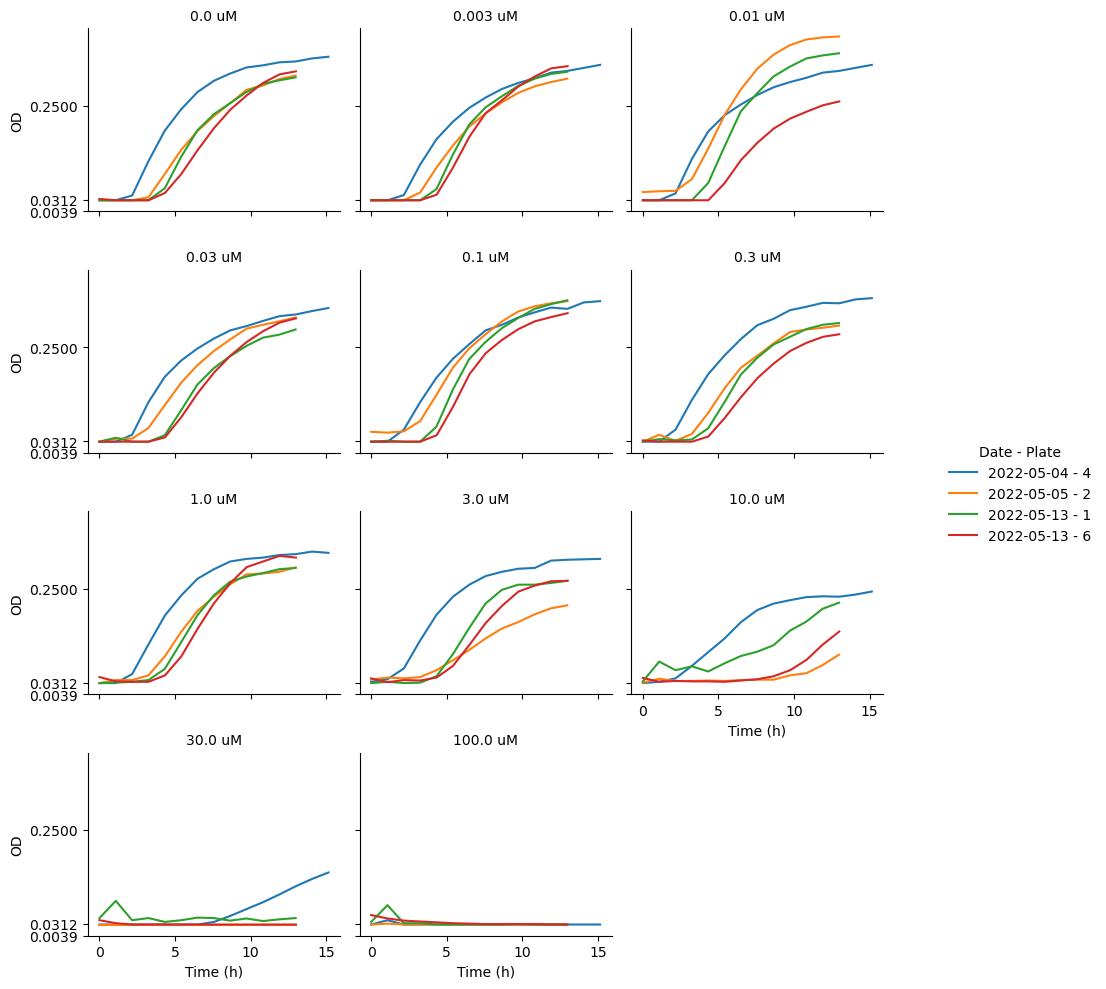

In [12]:
# Plot OD and time_h for all three days and all plates but exclude uM=-1
selected_dates = df['Date'].unique()

# Filter the DataFrame for the selected date
filtered_df = df[df['Date'].isin(selected_dates)]

# Filter the DataFrame to exclude um=-1
filtered_df = df[df['uM'] != -1].copy()

# Create a new column that combines Date and Plt for the hue
filtered_df.loc[:,'Date_Plt'] = df['Date'] + ' - ' + df['Plt'].astype(str)

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM',hue='Date_Plt', col_wrap=3, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'OD')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'OD')


# Set custom y-ticks
g.set(yticks=[0.00390625, 0.03125000,0.25000000])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)


# Adjust layout to prevent overlap
plt.tight_layout()


# Show the plot
plt.show()

## 0.2.2. Add Fit column

In [13]:
## ADDING FIT VALUES
# for each date AND Plt AND time_point, sort from uM to 0 and add OD mean of 0 to all
# then divide that OD from that value to get a Fit value


# Calculate mean OD for each Date_Plt_Timeh where uM == 0
mean_OD_zero = df[df['uM'] == 0].groupby('Date_Plt_Timeh')['OD'].mean()

# Add this series to the original DataFrame as the new column
df.loc[:, 'mean_OD_zero'] = df['Date_Plt_Timeh'].map(mean_OD_zero)

# Now add final FIT column
df.loc[:, 'Fit'] = df['OD'] / df['mean_OD_zero']

In [14]:
# Any values greater then 0.01 threshold will be given the value of 0.03
# df.loc[df['Fit'] > 1.1, 'Fit'] = 1.1

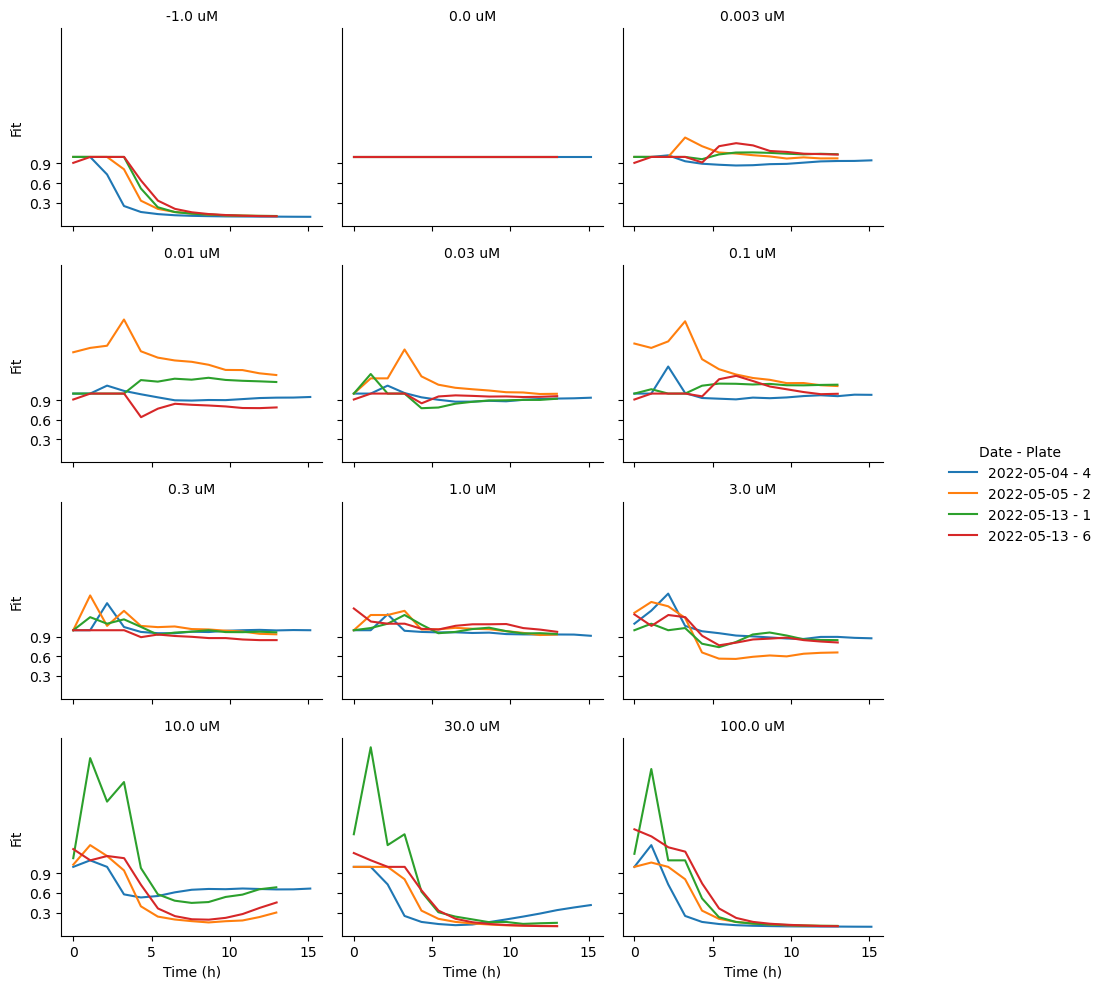

In [15]:
# Plot OD and time_h For all three days and all plates seperately
selected_dates = df['Date'].unique()

# Filter the DataFrame for the selected date
filtered_df = df[df['Date'].isin(selected_dates)]

# Filter the DataFrame to exclude um=-1
filtered_df = df[df['uM'] != -1].copy()

# Filter the DataFrame to display values less or equal to 1.1
filtered_df = df[df['OD'] <= 1.1].copy()

# Create a new column that combines Date and Plt for the hue
filtered_df.loc[:,'Date_Plt'] = filtered_df['Date'] + ' - ' + filtered_df['Plt'].astype(str)

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM',hue='Date_Plt', col_wrap=3, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'Fit')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'Fit')


g.set(yticks=[0.3, 0.6,0.9])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

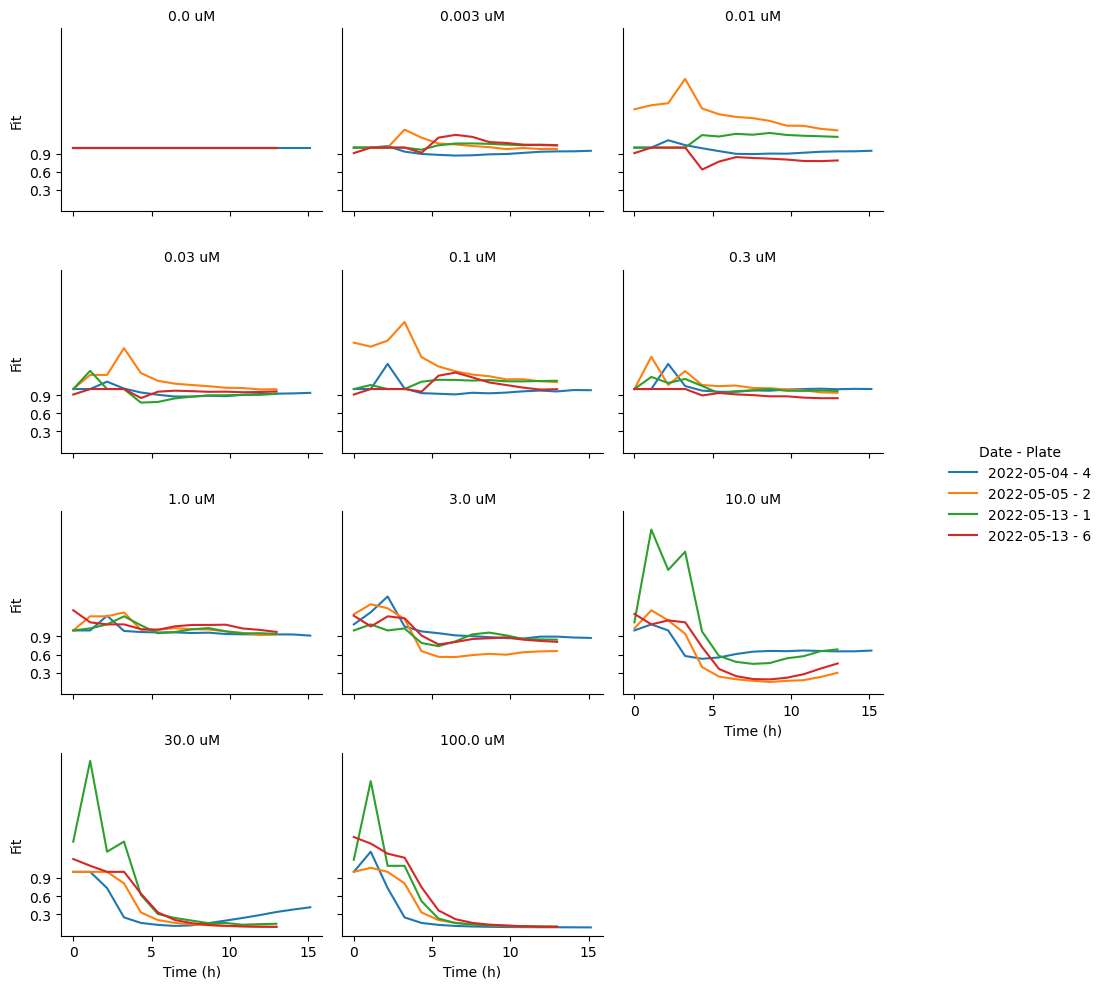

In [16]:
# Plot OD and time_h For all three days and all plates seperately
selected_dates = df['Date'].unique()

# Filter the DataFrame for the selected date
filtered_df = df[df['Date'].isin(selected_dates)]

# Filter the DataFrame to exclude um=-1
filtered_df = df[df['uM'] != -1].copy()

# Filter the DataFrame to display values less or equal to 1.1
#filtered_df = df[df['OD'] <= 1.1].copy()

# Create a new column that combines Date and Plt for the hue
filtered_df.loc[:,'Date_Plt'] = filtered_df['Date'] + ' - ' + filtered_df['Plt'].astype(str)

# Create a FacetGrid with subplots for each unique value of 'uM'
g = sns.FacetGrid(filtered_df, col='uM',hue='Date_Plt', col_wrap=3, height=2.5, sharex=True, sharey=True)

# Map the lineplot to each subplot
g.map(sns.lineplot, 'Time_h', 'Fit')

# Add titles and adjust layout
g.set_titles(col_template="{col_name} uM")
g.set_axis_labels('Time (h)', 'Fit')


g.set(yticks=[0.3, 0.6,0.9])

g.add_legend(title='Date - Plate', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# 0.3. Export results

In [17]:
df.to_csv('result/after_preprocessing.csv')

In [18]:
# filtering for Time_h between 9.5 and 10.5 h gives a desired result.
filtered_df = df[(df['Time_h'] > 9.5) & (df['Time_h'] < 10.5)]
filtered_df = filtered_df[filtered_df['uM'] != -1]
filtered_df = filtered_df[['uM','Fit']]

filtered_df.to_csv('result/only9.5_to10.5.csv')

In [19]:
# since the plotted data looks like s-curve so 2 parameter linear regression model will not be a good fit
# for this kind of data distribution we use 4 parameter logistic regression